# DEPRECIATED (see baseline_testing_evaluating_policies notebook for updated code)
Some of this code was used to generate initial plots for Baseline Testing doc. This is a first version of the code and very messy. The notebook above is a cleaner version that is easier to use.

In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")
from load_params import load_params

from multi_group_simulation import MultiGroupSimulation

## Importing Params, setting up group sim

In [2]:
ug_dorm_params = load_params('../src/simulations_v2/params/baseline_testing/ug_dorm.yaml')[1]
ug_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/ug_off_campus.yaml')[1]
gs_research_params = load_params('../src/simulations_v2/params/baseline_testing/grad_research.yaml')[1]
gs_other_params = load_params('../src/simulations_v2/params/baseline_testing/grad_other.yaml')[1]
faculty_staff_student_params = load_params('../src/simulations_v2/params/baseline_testing/faculty_staff_student_same_age.yaml')[1]
faculty_staff_non_student_params = load_params('../src/simulations_v2/params/baseline_testing/faculty_staff_non_student_same_age.yaml')[1]
faculty_staff_off_campus_params = load_params('../src/simulations_v2/params/baseline_testing/faculty_staff_off_campus_same_age.yaml')[1]
ithaca_community_params = load_params('../src/simulations_v2/params/baseline_testing/ithaca_community.yaml')[1]

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)


In [3]:
interaction_matrix = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,1.56],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,1.56],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,1.56],
                               [0.011,0.026,0.106,0.016,0.091,0.048,0.12,3.5]])

group_names = ['UG (campus)', 'UG (off campus)', 'GS (research)', 'GS (other)', 'Faculty/Staff (student facing)', 'Faculty/Staff (non student facing)', 'Faculty/Staff (off campus)', 'Ithaca Community']

## Miscellaneous Functions

In [4]:
def get_cum_hosp(df):
    return df[['severity_3', 'severity_2']].iloc[df.shape[0] - 1].sum()

def get_cum_outside_infections(df):
    return df['cumulative_outside_infections'].iloc[df.shape[0] - 1].sum()

def get_cum_infections(df):
    return df[['cumulative_mild', 'cumulative_severe']].iloc[df.shape[0] - 1].sum()

def total_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_infections(sim_df)
    return total

def total_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs:
        total += get_cum_hosp(sim_df)
    return total

def cornell_infections(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_infections(sim_df)
    return total

def cornell_hosp(list_sim_dfs):
    total = 0
    for sim_df in list_sim_dfs[:-1]:
        total += get_cum_hosp(sim_df)
    return total

In [5]:
def run_multigroup_sim(sim, T):
    sim_dfs = sim.run_new_trajectory(112)
    inf_list = list()
    hosp_list = list()
    for df in sim_dfs:
        inf_list.append(get_cum_infections(df))
        hosp_list.append(get_cum_hosp(df))
    return inf_list, hosp_list

def run_multiple_trajectories(sim, T, n):
    inf_matrix = list()
    hosp_matrix = list()
    for _ in range(n):
        result = run_multigroup_sim(sim, T)
        inf_matrix.append(result[0])
        hosp_matrix.append(result[1])
    return inf_matrix, hosp_matrix

In [6]:
def evaluate_testing_policy(params_list, interaction_matrix, group_names, test_frac, T, n):
    assert len(params_list) == len(test_frac)
    
    group_size = list()
    tests_per_day = 0
    
    # set group based contacts per day, test frequency
    for index, params in enumerate(params_list):
        params['expected_contacts_per_day'] = interaction_matrix[index, index]
        params['test_population_fraction'] = test_frac[index]
        group_size.append(params['population_size'])
        tests_per_day += group_size[-1] * test_frac[index]
    
    assert len(group_size) == len(test_frac)
    
    sim = MultiGroupSimulation(params_list, interaction_matrix, group_names)
    inf_matrix, hosp_matrix = run_multiple_trajectories(sim, T, n)
    return tests_per_day, inf_matrix, hosp_matrix

## Testing evaluate_testing_policy function

In [7]:
params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
results = list()

sample_test_policy = [2/7,2/7,2/7,2/7,1/7,1/7,1/7,0]
tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, sample_test_policy, 112, 3)
results.append({'test_policy': sample_test_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})
print(results)

[{'test_policy': [0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0], 'tests_per_day': 8214.428571428572, 'inf_matrix': [[288, 230, 35, 51, 62, 14, 25, 295], [296, 264, 48, 101, 80, 8, 32, 344], [281, 222, 26, 39, 52, 12, 25, 264]], 'hosp_matrix': [[2.35, 1.7999999999999998, 0.31666666666666665, 0.44999999999999996, 1.4584385119393461, 0.44875031136595267, 0.7105213263294251, 8.116941662126242], [2.283333333333333, 2.1, 0.3, 0.8166666666666667, 1.4958343712198423, 0.1869792964024803, 0.9348964820124014, 9.177446602906555], [2.2333333333333334, 1.7166666666666666, 0.11666666666666667, 0.36666666666666664, 1.1592716376953778, 0.2991668742439685, 0.5609378892074408, 7.668266494873032]]}]


In [8]:
interaction_matrix

array([[1.25e+01, 4.00e+00, 1.00e-01, 1.00e-01, 1.00e+00, 5.00e-02,
        5.00e-02, 1.00e-01],
       [3.41e+00, 8.00e+00, 1.00e-01, 1.00e-01, 1.00e+00, 5.00e-02,
        5.00e-02, 2.00e-01],
       [1.90e-01, 2.20e-01, 4.00e+00, 1.00e-01, 1.20e+00, 5.00e-02,
        2.00e-01, 1.80e+00],
       [1.40e-01, 1.70e-01, 7.00e-02, 9.00e+00, 1.00e+00, 5.00e-02,
        5.00e-02, 2.00e-01],
       [1.92e+00, 2.26e+00, 1.22e+00, 1.37e+00, 1.00e+00, 1.50e-01,
        3.00e-01, 1.56e+00],
       [1.80e-01, 2.10e-01, 1.00e-01, 1.30e-01, 2.80e-01, 1.80e+00,
        2.00e-01, 1.56e+00],
       [7.00e-02, 9.00e-02, 1.50e-01, 5.00e-02, 2.30e-01, 8.00e-02,
        1.80e+00, 1.56e+00],
       [1.10e-02, 2.60e-02, 1.06e-01, 1.60e-02, 9.10e-02, 4.80e-02,
        1.20e-01, 3.50e+00]])

## Evaluating a series of testing policies 

In [9]:
test_frac_policies = [[2/7,2/7,2/7,2/7,1/7,1/7,1/7,0],
[3/7,3/7,3/7,3/7,1/7,1/7,1/14,0],
[3/7,3/7,3/7,3/7,2/7,1/7,1/14,0],
[4/7,3/7,2/7,3/7,3/7,1/7,1/14,0],
[3/7,3/7,2/7,3/7,2/7,1/7,1/14,0],
[3/7,3/7,2/7,3/7,3/7,1/7,1/14,0],
[3/7,2/7,2/7,2/7,2/7,1/7,1/14,0],
[3/7,2/7,2/7,2/7,3/7,1/7,1/14,0],
[3/7, 3/7, 2/7, 2/7, 2/7, 1/7, 1/14, 0],
[4/7, 2/7, 2/7, 2/7, 2/7, 1/7, 1/14, 0],
[2/7, 2/7, 2/7, 2/7, 2/7, 2/7, 1/14, 0],
[1/7, 1/7, 1/7, 1/7, 1/7, 1/7, 1/14, 0]]

In [ ]:
results = list()

for policy in test_frac_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)
    results.append({'test_policy': sample_test_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0]


In [11]:
daily_tests = list()
inf = list()
inf_low = list()
inf_high = list()
hosp = list()
hosp_low = list()
hosp_high = list()
cornell_inf = list()
cornell_inf_low = list()
cornell_inf_high = list()
cornell_hosp = list()
cornell_hosp_low = list()
cornell_hosp_high = list()


for policy_dict in results:
    daily_tests.append(policy_dict['tests_per_day'])
    inf.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.5, axis=0))
    inf_low.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.1, axis=0))
    inf_high.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.9, axis=0))
    hosp.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.5, axis=0))
    hosp_low.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.1, axis=0))
    hosp_high.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.9, axis=0))

    cornell_inf.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.5, axis=0))
    cornell_inf_low.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.1, axis=0))
    cornell_inf_high.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.9, axis=0))
    cornell_hosp.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.5, axis=0))
    cornell_hosp_low.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.1, axis=0))
    cornell_hosp_high.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.9, axis=0))

In [23]:
np.array(results[0]['hosp_matrix'])
cornell_hosp
inf[:-1], np.array([np.array(inf)-np.array(inf_low), np.array(inf_high)-np.array(inf)])[:,:-1]

([1049.5,
  537.5,
  510.5,
  480.5,
  517.0,
  495.0,
  627.5,
  595.5,
  538.0,
  557.5,
  945.0],
 array([[289. ,  84.9,  99.3,  82.8,  98.6,  62.1, 130. ,  78.4,  52.6,
          71.5, 247.2],
        [335.8, 109.9,  83.7,  53.9,  83.3, 101.7, 158. , 134.1, 102.2,
         109.5, 348.1]]))

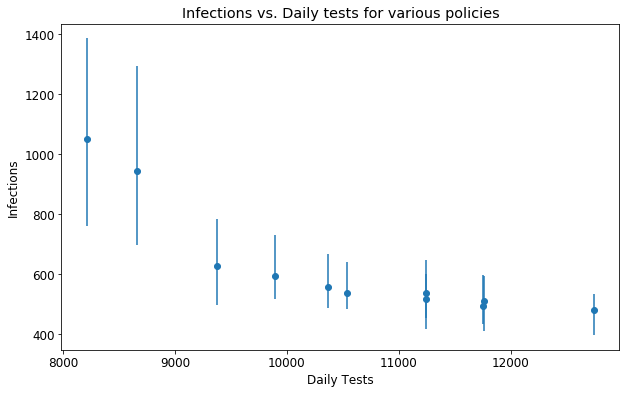

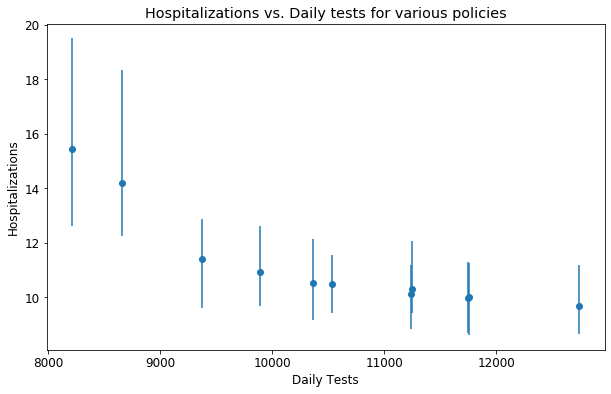

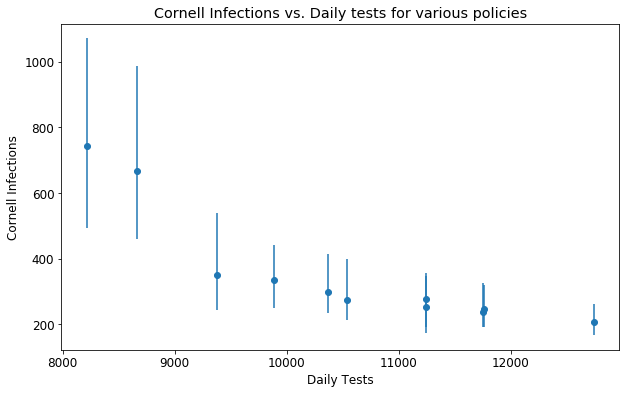

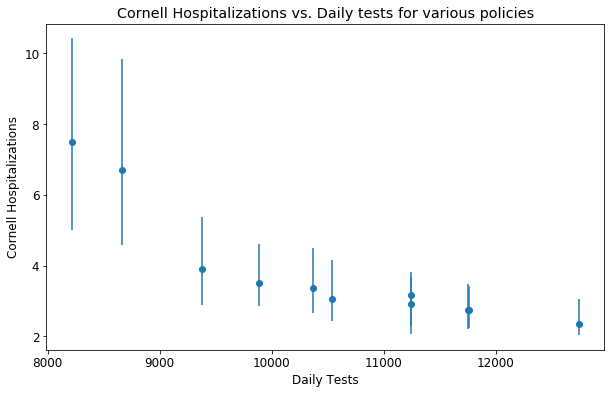

In [24]:
plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests[:-1], y=inf[:-1], yerr = np.array([np.array(inf)-np.array(inf_low), np.array(inf_high)-np.array(inf)])[:,:-1], fmt='o')
plt.title('Infections vs. Daily tests for various policies')
plt.ylabel('Infections')
plt.xlabel('Daily Tests')
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests[:-1], y=hosp[:-1], yerr = np.array([np.array(hosp)-np.array(hosp_low), np.array(hosp_high)-np.array(hosp)])[:,:-1], fmt='o')
plt.title('Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Hospitalizations')
plt.xlabel('Daily Tests')
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests[:-1], y=cornell_inf[:-1], yerr = np.array([np.array(cornell_inf)-np.array(cornell_inf_low), np.array(cornell_inf_high)-np.array(cornell_inf)])[:,:-1], fmt='o')
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests[:-1], y=cornell_hosp[:-1], yerr = np.array([np.array(cornell_hosp)-np.array(cornell_hosp_low), np.array(cornell_hosp_high)-np.array(cornell_hosp)])[:,:-1], fmt='o')
plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Cornell Hospitalizations')
plt.xlabel('Daily Tests')
plt.show()

In [28]:
# Cornell Policies
# [3/7,2/7,2/7,2/7,2/7,1/7,1/14,0],
# [3/7,2/7,2/7,2/7,3/7,1/7,1/14,0],

print(daily_tests[6:8])
print(inf[6:8])
print(inf_low[6:8])
print(inf_high[6:8])
print(hosp[6:8])
print(hosp_low[6:8])
print(hosp_high[6:8])
print(cornell_inf[6:8])
print(cornell_inf_low[6:8])
print(cornell_inf_high[6:8])
print(cornell_hosp[6:8])
print(cornell_hosp_low[6:8])
print(cornell_hosp_high[6:8])
# np.array([np.array(hosp)-np.array(hosp_low), np.array(hosp_high)-np.array(hosp)])

[9375.714285714284, 9889.714285714284]
[627.5, 595.5]
[497.5, 517.1]
[785.5, 729.5999999999999]
[11.415603725508092, 10.943796429131616]
[9.618458723498632, 9.674559501537393]
[12.863450006590687, 12.613730521563825]
[348.5, 335.0]
[244.2, 249.8]
[539.6, 441.20000000000005]
[3.899480334288989, 3.5021364415795935]
[2.8718135015604815, 2.8530112236234277]
[5.383167953645937, 4.605178180898315]


In [29]:
new_policies = [[2/7,1/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,2/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,2/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,2/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,1/7,2/7,1/30,0],
[2/7,2/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,2/7,2/7,1/7,2/7,1/7,1/30,0]]

In [38]:
for policy in new_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 50)
    results.append({'test_policy': policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285,

In [72]:
daily_tests = list()
inf = list()
inf_low = list()
inf_high = list()
hosp = list()
hosp_low = list()
hosp_high = list()
cornell_inf = list()
cornell_inf_low = list()
cornell_inf_high = list()
cornell_hosp = list()
cornell_hosp_low = list()
cornell_hosp_high = list()
test_policy_ug_dorm = list()
test_policy_ug_off_campus = list()
test_policy_grad_research = list()
test_policy_grad_other = list()
test_policy_staff_student = list()
test_policy_staff_non_student = list()
test_policy_staff_off_campus = list()
test_policy = list()

for policy_dict in results:
    daily_tests.append(policy_dict['tests_per_day'])
    inf.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.5, axis=0))
    inf_low.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.1, axis=0))
    inf_high.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.9, axis=0))
    hosp.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.5, axis=0))
    hosp_low.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.1, axis=0))
    hosp_high.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.9, axis=0))

    cornell_inf.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.5, axis=0))
    cornell_inf_low.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.1, axis=0))
    cornell_inf_high.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.9, axis=0))
    cornell_hosp.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.5, axis=0))
    cornell_hosp_low.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.1, axis=0))
    cornell_hosp_high.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.9, axis=0))

for policy in test_frac_policies + new_policies:
    test_policy_ug_dorm.append(int(policy[0]*7))
    test_policy_ug_off_campus.append(int(policy[1]*7))
    test_policy_grad_research.append(int(policy[2]*7))
    test_policy_grad_other.append(int(policy[3]*7))
    test_policy_staff_student.append(int(policy[4]*7))
    test_policy_staff_non_student.append(int(policy[5]*7))
    test_policy_staff_off_campus.append(policy[6]*7)
    test_policy_string = '['
    for frequency in policy[:-2]:
        test_policy_string += str(int(frequency * 7)) + ','
    test_policy_string += str(np.round(policy[-2] * 7, 2))
    test_policy_string += ']'
    test_policy.append(test_policy_string)

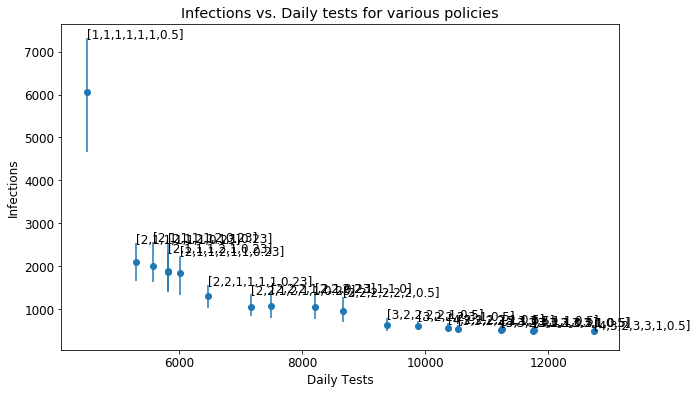

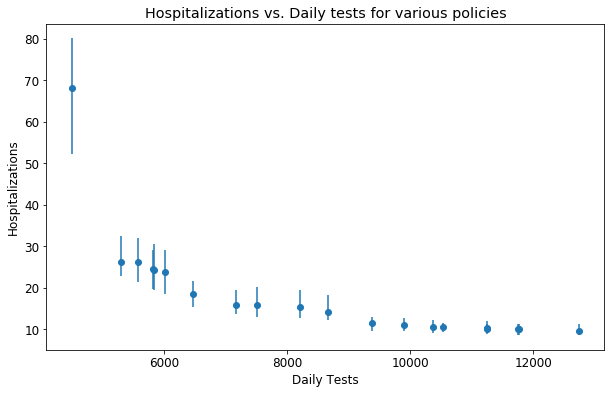

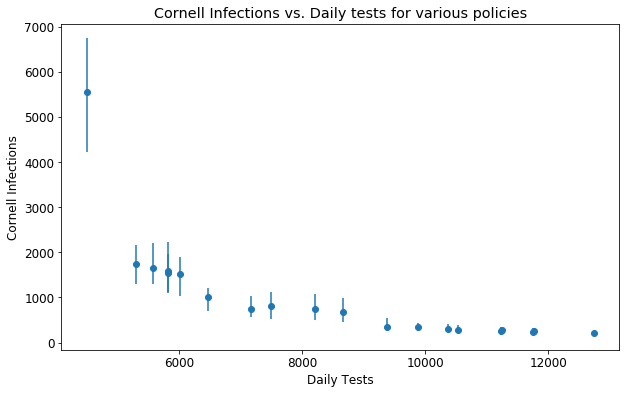

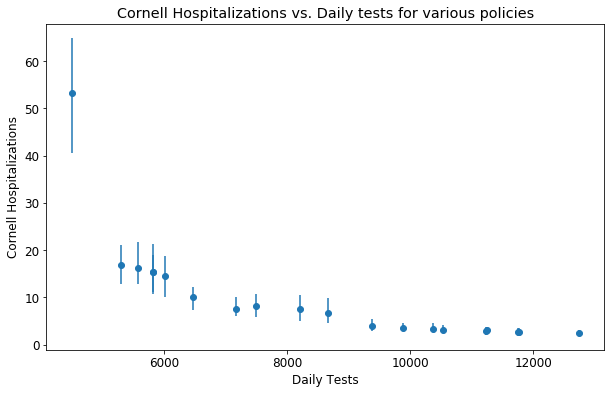

In [73]:
plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests, y=inf, yerr = np.array([np.array(inf)-np.array(inf_low), np.array(inf_high)-np.array(inf)]), fmt='o')
# for index, policy in enumerate(test_policy):
#     plt.annotate(policy, xy = (daily_tests[index], inf_high[index]), xytext=(daily_tests[index], inf_high[index] + ), arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Infections vs. Daily tests for various policies')
plt.ylabel('Infections')
plt.xlabel('Daily Tests')
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests, y=hosp, yerr = np.array([np.array(hosp)-np.array(hosp_low), np.array(hosp_high)-np.array(hosp)]), fmt='o')
plt.title('Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Hospitalizations')
plt.xlabel('Daily Tests')
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests, y=cornell_inf, yerr = np.array([np.array(cornell_inf)-np.array(cornell_inf_low), np.array(cornell_inf_high)-np.array(cornell_inf)]), fmt='o')
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests, y=cornell_hosp, yerr = np.array([np.array(cornell_hosp)-np.array(cornell_hosp_low), np.array(cornell_hosp_high)-np.array(cornell_hosp)]), fmt='o')
plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Cornell Hospitalizations')
plt.xlabel('Daily Tests')
plt.show()

In [75]:
# Collecting raw data to present
import pandas as pd
plotting_data = pd.DataFrame({'daily_tests': daily_tests, 'inf': inf, 'inf_low': inf_low, 'inf_high': inf_high, 'hosp': hosp,
              'hosp_low': hosp_low, 'hosp_high': hosp_high, 'cornell_inf': cornell_inf, 'cornell_inf_low': cornell_inf_low,
              'cornell_inf_high': cornell_inf_high, 'cornell_hosp': cornell_hosp, 'cornell_hosp_low': cornell_hosp_low,
              'cornell_hosp_high': cornell_hosp_high, 'test_policy_ug_dorm': test_policy_ug_dorm,
              'test_policy_ug_off_campus': test_policy_ug_off_campus,
              'test_policy_grad_research': test_policy_grad_research, 'test_policy_grad_other': test_policy_grad_other,
              'test_policy_staff_student': test_policy_staff_student,
              'test_policy_staff_non_student': test_policy_staff_non_student,
              'test_policy_staff_off_campus': test_policy_staff_off_campus,
              'test_policy': test_policy})

# Annotating Plots

In [116]:
plotting_data['inf_yerr_low'] = plotting_data['inf'] - plotting_data['inf_low']
plotting_data['inf_yerr_high'] = plotting_data['inf_high'] - plotting_data['inf']
plotting_data['hosp_yerr_low'] = plotting_data['hosp'] - plotting_data['hosp_low']
plotting_data['hosp_yerr_high'] = plotting_data['hosp_high'] - plotting_data['hosp']
plotting_data['cornell_inf_yerr_low'] = plotting_data['cornell_inf'] - plotting_data['cornell_inf_low']
plotting_data['cornell_inf_yerr_high'] = plotting_data['cornell_inf_high'] - plotting_data['cornell_inf']
plotting_data['cornell_hosp_yerr_low'] = plotting_data['cornell_hosp'] - plotting_data['cornell_hosp_low']
plotting_data['cornell_hosp_yerr_high'] = plotting_data['cornell_hosp_high'] - plotting_data['cornell_hosp']
plotting_data

,daily_tests,inf,inf_low,inf_high,hosp,hosp_low,hosp_high,cornell_inf,cornell_inf_low,cornell_inf_high,...,test_policy_grad_research,test_policy_grad_other,test_policy_staff_student,test_policy_staff_non_student,test_policy_staff_off_campus,test_policy,inf_yerr_low,inf_yerr_high,hosp_yerr_low,hosp_yerr_high
0,4500.428571,6051.0,4655.7,7306.5,67.995293,52.166648,80.023613,5547.5,4221.9,6736.5,...,1,1,1,1,0.500000,"[1,1,1,1,1,1,0.5]",1395.3,1255.5,15.828645,12.028320
1,5306.980952,2101.5,1656.6,2533.6,26.295456,22.752015,32.518841,1742.5,1305.1,2150.7,...,1,1,1,1,0.233333,"[2,1,1,1,1,1,0.23]",444.9,432.1,3.543441,6.223385
2,5579.409524,1996.0,1624.8,2575.7,26.187806,21.495907,32.077157,1657.0,1297.6,2198.5,...,1,1,1,2,0.233333,"[2,1,1,1,1,2,0.23]",371.2,579.7,4.691899,5.889352
3,5820.980952,1886.5,1404.9,2323.7,24.578610,19.670140,29.042572,1581.5,1093.4,1958.2,...,1,1,2,1,0.233333,"[2,1,1,1,2,1,0.23]",481.6,437.2,4.908470,4.463962
4,5827.695238,1863.0,1422.3,2547.1,24.192472,19.508055,30.584736,1536.5,1123.0,2219.6,...,2,1,1,1,0.233333,"[2,1,2,1,1,1,0.23]",440.7,684.1,4.684417,6.392264
5,6009.980952,1849.5,1334.4,2243.6,23.689429,18.555247,28.970915,1509.5,1020.3,1884.2,...,1,2,1,1,0.233333,"[2,1,1,2,1,1,0.23]",515.1,394.1,5.134181,5.281486
6,6467.409524,1315.0,1020.1,1557.1,18.547815,15.337651,21.653845,1016.5,706.5,1213.8,...,1,1,1,1,0.233333,"[2,2,1,1,1,1,0.23]",294.9,242.1,3.210163,3.106031
7,7170.409524,1047.5,851.3,1347.2,15.899748,13.588710,19.493778,735.5,573.5,1031.7,...,1,2,1,1,0.233333,"[2,2,1,2,1,1,0.23]",196.2,299.7,2.311038,3.594030
8,7502.123810,1081.5,788.3,1399.4,15.842747,12.978932,20.056968,807.5,530.5,1111.2,...,2,1,2,1,0.233333,"[2,2,2,1,2,1,0.23]",293.2,317.9,2.863815,4.214221
9,8214.428571,1049.5,760.5,1385.3,15.445471,12.613687,19.492305,743.0,494.4,1070.8,...,2,2,1,1,1.000000,"[2,2,2,2,1,1,1.0]",289.0,335.8,2.831784,4.046835


In [105]:
# plotting_data = plotting_data.sort_values('daily_tests')
plotting_data = plotting_data.reset_index(drop=True)

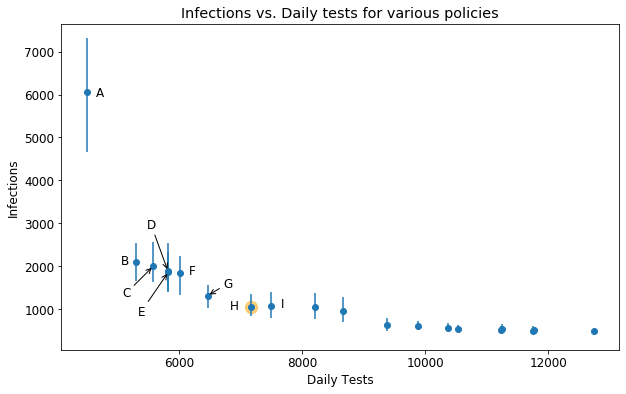

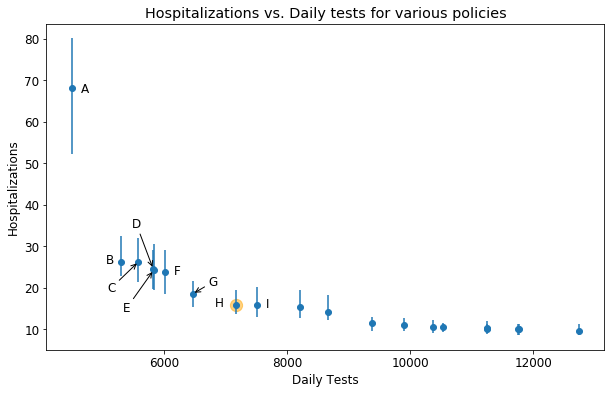

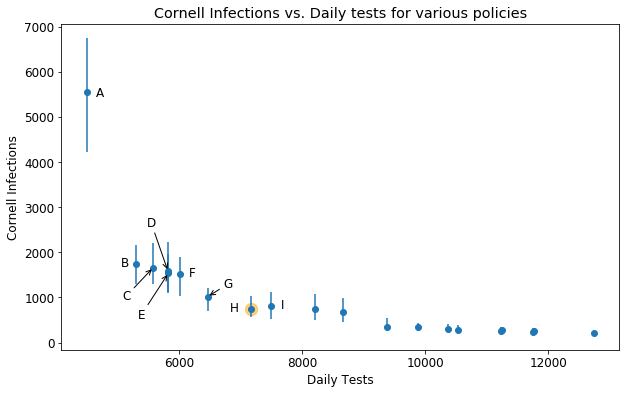

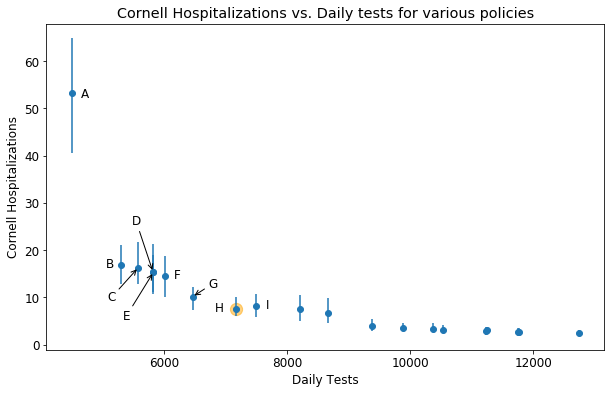

In [225]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data['inf_yerr_low'],plotting_data['inf_yerr_high']], fmt='o', data=plotting_data)
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['inf'][7],c='orange',s=150,alpha=0.5)
text_x = [150, -250, -500, -350, -500, 150, 250, -350, 150]
text_y = [-100, -50, -700, 1000, -1000, -50, 200, -50, -50]
arrow = [False, False, True, True, True, False, True, False, False]
annotation_text = ['A','B','C','D','E','F','G','H','I']
for index in range(len(text_x)):
    if arrow[index] == True:
        plt.annotate(annotation_text[index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    else:
        plt.annotate(annotation_text[index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data')
plt.title('Infections vs. Daily tests for various policies')
plt.ylabel('Infections')
plt.xlabel('Daily Tests')
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests, y=hosp, yerr = np.array([np.array(hosp)-np.array(hosp_low), np.array(hosp_high)-np.array(hosp)]), fmt='o')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['hosp'][7],c='orange',s=150,alpha=0.5)
text_x = [150, -250, -500, -350, -500, 150, 250, -350, 150]
text_y = [-1, -0.5, -7, 10, -10, -0.5, 2, -0.5, -0.5]
arrow = [False, False, True, True, True, False, True, False, False]
for index in range(len(text_x)):
    if arrow[index] == True:
        plt.annotate(annotation_text[index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    else:
        plt.annotate(annotation_text[index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data')
plt.title('Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Hospitalizations')
plt.xlabel('Daily Tests')
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests, y=cornell_inf, yerr = np.array([np.array(cornell_inf)-np.array(cornell_inf_low), np.array(cornell_inf_high)-np.array(cornell_inf)]), fmt='o')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['cornell_inf'][7],c='orange',s=150,alpha=0.5)
text_x = [150, -250, -500, -350, -500, 150, 250, -350, 150]
text_y = [-100, -50, -700, 1000, -1000, -50, 200, -50, -50]
arrow = [False, False, True, True, True, False, True, False, False]
for index in range(len(text_x)):
    if arrow[index] == True:
        plt.annotate(annotation_text[index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    else:
        plt.annotate(annotation_text[index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data')
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x=daily_tests, y=cornell_hosp, yerr = np.array([np.array(cornell_hosp)-np.array(cornell_hosp_low), np.array(cornell_hosp_high)-np.array(cornell_hosp)]), fmt='o')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['cornell_hosp'][7],c='orange',s=150,alpha=0.5)
text_x = [150, -250, -500, -350, -500, 150, 250, -350, 150]
text_y = [-1, -0.5, -7, 10, -10, -0.5, 2, -0.5, -0.5]
arrow = [False, False, True, True, True, False, True, False, False]
for index in range(len(text_x)):
    if arrow[index] == True:
        plt.annotate(annotation_text[index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
    else:
        plt.annotate(annotation_text[index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data')
plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Cornell Hospitalizations')
plt.xlabel('Daily Tests')
plt.show()

# Alternate Contact Matricies

In [136]:
limited_policies = [[1/7,1/7,1/7,1/7,1/7,1/7,1/14,0],
[2/7,1/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,2/7,1/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,2/7,1/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,2/7,1/7,1/30,0],
[2/7,1/7,1/7,1/7,1/7,2/7,1/30,0],
[2/7,2/7,1/7,2/7,1/7,1/7,1/30,0],
[2/7,2/7,2/7,1/7,2/7,1/7,1/30,0]]

In [137]:
results_30 = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, 1.3*interaction_matrix, group_names, policy, 112, 50)
    results_30.append({'test_policy': sample_test_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857

In [166]:
results_50 = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, 1.5*interaction_matrix, group_names, policy, 112, 50)
    results_50.append({'test_policy': sample_test_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]
Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.2857142857142857

In [172]:
# results_50 = results_30[9:]
# results_30 = results_30[:9]

In [174]:
daily_tests_30 = list()
inf_30 = list()
inf_low_30 = list()
inf_high_30 = list()
hosp_30 = list()
hosp_low_30 = list()
hosp_high_30 = list()
cornell_inf_30 = list()
cornell_inf_low_30 = list()
cornell_inf_high_30 = list()
cornell_hosp_30 = list()
cornell_hosp_low_30 = list()
cornell_hosp_high_30 = list()
test_policy_ug_dorm_30 = list()
test_policy_ug_off_campus_30 = list()
test_policy_grad_research_30 = list()
test_policy_grad_other_30 = list()
test_policy_staff_student_30 = list()
test_policy_staff_non_student_30 = list()
test_policy_staff_off_campus_30 = list()
test_policy_30 = list()

for policy_dict in results_30:
    daily_tests_30.append(policy_dict['tests_per_day'])
    inf_30.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.5, axis=0))
    inf_low_30.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.1, axis=0))
    inf_high_30.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.9, axis=0))
    hosp_30.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.5, axis=0))
    hosp_low_30.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.1, axis=0))
    hosp_high_30.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.9, axis=0))

    cornell_inf_30.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.5, axis=0))
    cornell_inf_low_30.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.1, axis=0))
    cornell_inf_high_30.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.9, axis=0))
    cornell_hosp_30.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.5, axis=0))
    cornell_hosp_low_30.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.1, axis=0))
    cornell_hosp_high_30.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.9, axis=0))

for policy in limited_policies:
    test_policy_ug_dorm_30.append(int(policy[0]*7))
    test_policy_ug_off_campus_30.append(int(policy[1]*7))
    test_policy_grad_research_30.append(int(policy[2]*7))
    test_policy_grad_other_30.append(int(policy[3]*7))
    test_policy_staff_student_30.append(int(policy[4]*7))
    test_policy_staff_non_student_30.append(int(policy[5]*7))
    test_policy_staff_off_campus_30.append(policy[6]*7)
    test_policy_string = '['
    for frequency in policy[:-2]:
        test_policy_string += str(int(frequency * 7)) + ','
    test_policy_string += str(np.round(policy[-2] * 7, 2))
    test_policy_string += ']'
    test_policy_30.append(test_policy_string)

In [179]:
plotting_data_30 = pd.DataFrame({'daily_tests': daily_tests_30, 'inf': inf_30, 'inf_low': inf_low_30, 'inf_high': inf_high_30, 'hosp': hosp_30,
              'hosp_low': hosp_low_30, 'hosp_high': hosp_high_30, 'cornell_inf': cornell_inf_30, 'cornell_inf_low': cornell_inf_low_30,
              'cornell_inf_high': cornell_inf_high_30, 'cornell_hosp': cornell_hosp_30, 'cornell_hosp_low': cornell_hosp_low_30,
              'cornell_hosp_high': cornell_hosp_high_30, 'test_policy_ug_dorm': test_policy_ug_dorm_30,
              'test_policy_ug_off_campus': test_policy_ug_off_campus_30,
              'test_policy_grad_research': test_policy_grad_research_30, 'test_policy_grad_other': test_policy_grad_other_30,
              'test_policy_staff_student': test_policy_staff_student_30,
              'test_policy_staff_non_student': test_policy_staff_non_student_30,
              'test_policy_staff_off_campus': test_policy_staff_off_campus_30,
              'test_policy': test_policy_30})

plotting_data_30['inf_yerr_low'] = plotting_data_30['inf'] - plotting_data_30['inf_low']
plotting_data_30['inf_yerr_high'] = plotting_data_30['inf_high'] - plotting_data_30['inf']
plotting_data_30['hosp_yerr_low'] = plotting_data_30['hosp'] - plotting_data_30['hosp_low']
plotting_data_30['hosp_yerr_high'] = plotting_data_30['hosp_high'] - plotting_data_30['hosp']
plotting_data_30['cornell_inf_yerr_low'] = plotting_data_30['cornell_inf'] - plotting_data_30['cornell_inf_low']
plotting_data_30['cornell_inf_yerr_high'] = plotting_data_30['cornell_inf_high'] - plotting_data_30['cornell_inf']
plotting_data_30['cornell_hosp_yerr_low'] = plotting_data_30['cornell_hosp'] - plotting_data_30['cornell_hosp_low']
plotting_data_30['cornell_hosp_yerr_high'] = plotting_data_30['cornell_hosp_high'] - plotting_data_30['cornell_hosp']
plotting_data_30

,daily_tests,inf,inf_low,inf_high,hosp,hosp_low,hosp_high,cornell_inf,cornell_inf_low,cornell_inf_high,...,test_policy_staff_off_campus,test_policy,inf_yerr_low,inf_yerr_high,hosp_yerr_low,hosp_yerr_high,cornell_inf_yerr_low,cornell_inf_yerr_high,cornell_hosp_yerr_low,cornell_hosp_yerr_high
0,4500.428571,15363.5,14927.9,15730.5,181.946682,175.470466,186.553839,13771.5,13399.1,14062.7,...,0.500000,"[1,1,1,1,1,1,0.5]",435.6,367.0,6.476216,4.607157,372.4,291.2,3.911105,3.844584
1,5306.980952,9032.0,7726.1,9943.6,105.978420,92.878780,117.006242,8030.5,6854.1,8866.3,...,0.233333,"[2,1,1,1,1,1,0.23]",1305.9,911.6,13.099640,11.027822,1176.4,835.8,10.616513,8.141073
2,6467.409524,4511.0,3895.8,5224.4,55.911789,49.596244,64.450937,3846.5,3254.5,4527.4,...,0.233333,"[2,2,1,1,1,1,0.23]",615.2,713.4,6.315545,8.539148,592.0,680.9,5.273771,7.663419
3,5827.695238,8907.0,8151.6,9945.0,104.099350,93.758965,114.616198,7995.5,7335.3,8929.4,...,0.233333,"[2,1,2,1,1,1,0.23]",755.4,1038.0,10.340385,10.516848,660.2,933.9,6.581137,8.619303
4,6009.980952,8178.5,7485.1,9165.6,95.989625,89.661046,107.988006,7290.5,6586.4,8228.1,...,0.233333,"[2,1,1,2,1,1,0.23]",693.4,987.1,6.328578,11.998382,704.1,937.6,6.099105,9.013606
5,5820.980952,8147.5,7070.8,9033.2,95.456969,82.144960,104.313740,7333.0,6285.3,8129.5,...,0.233333,"[2,1,1,1,2,1,0.23]",1076.7,885.7,13.312009,8.856770,1047.7,796.5,9.930741,8.333553
6,5579.409524,9333.5,8034.8,10095.4,109.627689,96.241216,117.307691,8288.5,7125.5,9022.6,...,0.233333,"[2,1,1,1,1,2,0.23]",1298.7,761.9,13.386473,7.680003,1163.0,734.1,10.228720,6.916554
7,7170.409524,3534.5,2963.7,4182.0,44.838116,38.850115,52.731806,2930.0,2451.5,3603.1,...,0.233333,"[2,2,1,2,1,1,0.23]",570.8,647.5,5.988001,7.893689,478.5,673.1,5.231074,5.800543
8,7502.123810,3793.5,2909.0,4455.7,46.388781,36.509872,53.468812,3260.5,2497.6,3919.8,...,0.233333,"[2,2,2,1,2,1,0.23]",884.5,662.2,9.878908,7.080032,762.9,659.3,7.577136,5.550554


In [187]:
daily_tests_50 = list()
inf_50 = list()
inf_low_50 = list()
inf_high_50 = list()
hosp_50 = list()
hosp_low_50 = list()
hosp_high_50 = list()
cornell_inf_50 = list()
cornell_inf_low_50 = list()
cornell_inf_high_50 = list()
cornell_hosp_50 = list()
cornell_hosp_low_50 = list()
cornell_hosp_high_50 = list()
test_policy_ug_dorm_50 = list()
test_policy_ug_off_campus_50 = list()
test_policy_grad_research_50 = list()
test_policy_grad_other_50 = list()
test_policy_staff_student_50 = list()
test_policy_staff_non_student_50 = list()
test_policy_staff_off_campus_50 = list()
test_policy_50 = list()

for policy_dict in results_50:
    daily_tests_50.append(policy_dict['tests_per_day'])
    inf_50.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.5, axis=0))
    inf_low_50.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.1, axis=0))
    inf_high_50.append(np.quantile(np.sum(policy_dict['inf_matrix'], axis=1), 0.9, axis=0))
    hosp_50.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.5, axis=0))
    hosp_low_50.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.1, axis=0))
    hosp_high_50.append(np.quantile(np.sum(policy_dict['hosp_matrix'], axis=1), 0.9, axis=0))

    cornell_inf_50.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.5, axis=0))
    cornell_inf_low_50.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.1, axis=0))
    cornell_inf_high_50.append(np.quantile(np.sum(np.array(policy_dict['inf_matrix'])[:,:-1], axis=1), 0.9, axis=0))
    cornell_hosp_50.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.5, axis=0))
    cornell_hosp_low_50.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.1, axis=0))
    cornell_hosp_high_50.append(np.quantile(np.sum(np.array(policy_dict['hosp_matrix'])[:,:-1], axis=1), 0.9, axis=0))

for policy in limited_policies:
    test_policy_ug_dorm_50.append(int(policy[0]*7))
    test_policy_ug_off_campus_50.append(int(policy[1]*7))
    test_policy_grad_research_50.append(int(policy[2]*7))
    test_policy_grad_other_50.append(int(policy[3]*7))
    test_policy_staff_student_50.append(int(policy[4]*7))
    test_policy_staff_non_student_50.append(int(policy[5]*7))
    test_policy_staff_off_campus_50.append(policy[6]*7)
    test_policy_string = '['
    for frequency in policy[:-2]:
        test_policy_string += str(int(frequency * 7)) + ','
    test_policy_string += str(np.round(policy[-2] * 7, 2))
    test_policy_string += ']'
    test_policy_50.append(test_policy_string)

In [188]:
plotting_data_50 = pd.DataFrame({'daily_tests': daily_tests_50, 'inf': inf_50, 'inf_low': inf_low_50, 'inf_high': inf_high_50, 'hosp': hosp_50,
              'hosp_low': hosp_low_50, 'hosp_high': hosp_high_50, 'cornell_inf': cornell_inf_50, 'cornell_inf_low': cornell_inf_low_50,
              'cornell_inf_high': cornell_inf_high_50, 'cornell_hosp': cornell_hosp_50, 'cornell_hosp_low': cornell_hosp_low_50,
              'cornell_hosp_high': cornell_hosp_high_50, 'test_policy_ug_dorm': test_policy_ug_dorm_50,
              'test_policy_ug_off_campus': test_policy_ug_off_campus_50,
              'test_policy_grad_research': test_policy_grad_research_50, 'test_policy_grad_other': test_policy_grad_other_50,
              'test_policy_staff_student': test_policy_staff_student_50,
              'test_policy_staff_non_student': test_policy_staff_non_student_50,
              'test_policy_staff_off_campus': test_policy_staff_off_campus_50,
              'test_policy': test_policy_50})

plotting_data_50['inf_yerr_low'] = plotting_data_50['inf'] - plotting_data_50['inf_low']
plotting_data_50['inf_yerr_high'] = plotting_data_50['inf_high'] - plotting_data_50['inf']
plotting_data_50['hosp_yerr_low'] = plotting_data_50['hosp'] - plotting_data_50['hosp_low']
plotting_data_50['hosp_yerr_high'] = plotting_data_50['hosp_high'] - plotting_data_50['hosp']
plotting_data_50['cornell_inf_yerr_low'] = plotting_data_50['cornell_inf'] - plotting_data_50['cornell_inf_low']
plotting_data_50['cornell_inf_yerr_high'] = plotting_data_50['cornell_inf_high'] - plotting_data_50['cornell_inf']
plotting_data_50['cornell_hosp_yerr_low'] = plotting_data_50['cornell_hosp'] - plotting_data_50['cornell_hosp_low']
plotting_data_50['cornell_hosp_yerr_high'] = plotting_data_50['cornell_hosp_high'] - plotting_data_50['cornell_hosp']
plotting_data_50

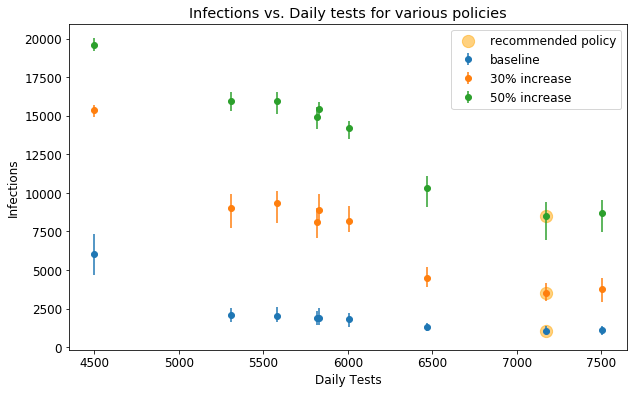

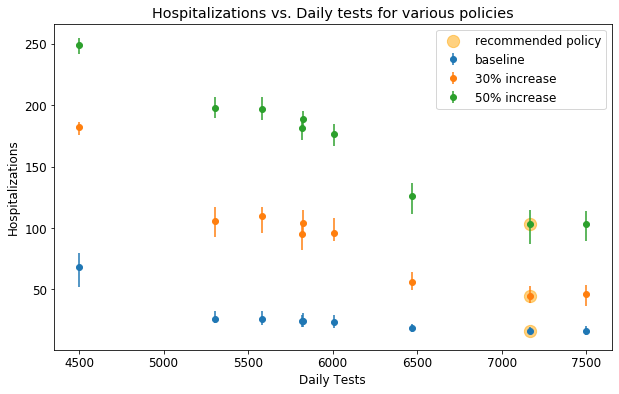

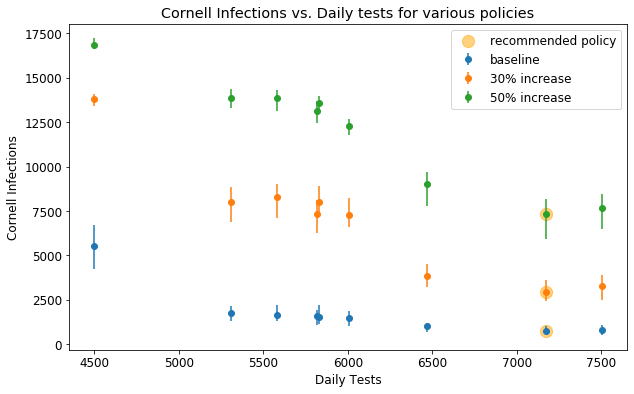

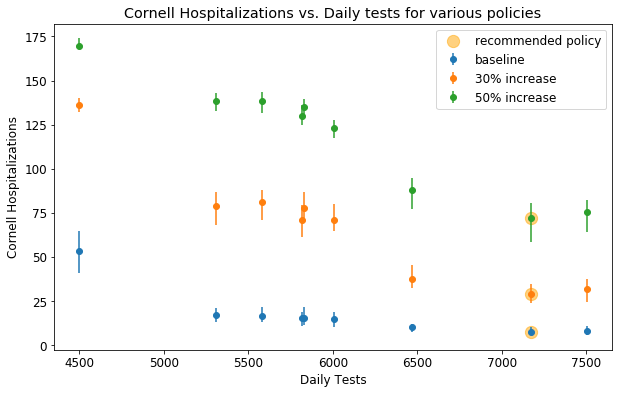

In [196]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data.head(9)['inf_yerr_low'],plotting_data.head(9)['inf_yerr_high']], fmt='o', data=plotting_data.head(9), label='baseline')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['inf'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data_30['inf_yerr_low'],plotting_data_30['inf_yerr_high']], fmt='o', data=plotting_data_30, label="30% increase")
plt.scatter(x=plotting_data_30['daily_tests'][7], y=plotting_data_30['inf'][7],c='orange',s=150,alpha=0.5)
plt.errorbar(x='daily_tests', y='inf', yerr = [plotting_data_50['inf_yerr_low'],plotting_data_50['inf_yerr_high']], fmt='o', data=plotting_data_50, label="50% increase")
plt.scatter(x=plotting_data_50['daily_tests'][7], y=plotting_data_50['inf'][7],c='orange',s=150,alpha=0.5)
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Infections vs. Daily tests for various policies')
plt.ylabel('Infections')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data.head(9)['hosp_yerr_low'],plotting_data.head(9)['hosp_yerr_high']], fmt='o', data=plotting_data.head(9), label='baseline')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['hosp'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data_30['hosp_yerr_low'],plotting_data_30['hosp_yerr_high']], fmt='o', data=plotting_data_30, label='30% increase')
plt.scatter(x=plotting_data_30['daily_tests'][7], y=plotting_data_30['hosp'][7],c='orange',s=150,alpha=0.5)
plt.errorbar(x='daily_tests', y='hosp', yerr = [plotting_data_50['hosp_yerr_low'],plotting_data_50['hosp_yerr_high']], fmt='o', data=plotting_data_50, label="50% increase")
plt.scatter(x=plotting_data_50['daily_tests'][7], y=plotting_data_50['hosp'][7],c='orange',s=150,alpha=0.5)
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Hospitalizations')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data.head(9)['cornell_inf_yerr_low'],plotting_data.head(9)['cornell_inf_yerr_high']], fmt='o', data=plotting_data.head(9), label='baseline')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['cornell_inf'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data_30['cornell_inf_yerr_low'],plotting_data_30['cornell_inf_yerr_high']], fmt='o', data=plotting_data_30, label='30% increase')
plt.scatter(x=plotting_data_30['daily_tests'][7], y=plotting_data_30['cornell_inf'][7],c='orange',s=150,alpha=0.5)
plt.errorbar(x='daily_tests', y='cornell_inf', yerr = [plotting_data_50['cornell_inf_yerr_low'],plotting_data_50['cornell_inf_yerr_high']], fmt='o', data=plotting_data_50, label='50% increase')
plt.scatter(x=plotting_data_50['daily_tests'][7], y=plotting_data_50['cornell_inf'][7],c='orange',s=150,alpha=0.5)
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 1500, -1000, 1000, -1500, 500, 600, 450, -700]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_inf'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_inf'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Infections vs. Daily tests for various policies')
plt.ylabel('Cornell Infections')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()


plt.figure(figsize=(10,6))
plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data.head(9)['cornell_hosp_yerr_low'],plotting_data.head(9)['cornell_hosp_yerr_high']], fmt='o', data=plotting_data.head(9), label='baseline')
plt.scatter(x=plotting_data['daily_tests'][7], y=plotting_data['cornell_hosp'][7],c='orange',s=150,alpha=0.5, label='recommended policy')
plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data_30['cornell_hosp_yerr_low'],plotting_data_30['cornell_hosp_yerr_high']], fmt='o', data=plotting_data_30, label='30% increase')
plt.scatter(x=plotting_data_30['daily_tests'][7], y=plotting_data_30['cornell_hosp'][7],c='orange',s=150,alpha=0.5)
plt.errorbar(x='daily_tests', y='cornell_hosp', yerr = [plotting_data_50['cornell_hosp_yerr_low'],plotting_data_50['cornell_hosp_yerr_high']], fmt='o', data=plotting_data_50, label='50% increase')
plt.scatter(x=plotting_data_50['daily_tests'][7], y=plotting_data_50['cornell_hosp'][7],c='orange',s=150,alpha=0.5)
# text_x = [300, -1000, -1250, -500, -500, 0, 0, -200, 0]
# text_y = [0, 15, -10, 12, -15, 7, 7, 4.5, -7]
# for index in range(len(text_x)):
#     plt.annotate(plotting_data['test_policy'][index], xy = (plotting_data['daily_tests'][index], plotting_data['cornell_hosp'][index]), xycoords = 'data', xytext=(plotting_data['daily_tests'][index] + text_x[index], plotting_data['cornell_hosp'][index] + text_y[index]), textcoords = 'data', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.title('Cornell Hospitalizations vs. Daily tests for various policies')
plt.ylabel('Cornell Hospitalizations')
plt.xlabel('Daily Tests')
plt.legend()
plt.show()

In [185]:
plotting_data.head(9)

,daily_tests,inf,inf_low,inf_high,hosp,hosp_low,hosp_high,cornell_inf,cornell_inf_low,cornell_inf_high,...,test_policy_grad_research,test_policy_grad_other,test_policy_staff_student,test_policy_staff_non_student,test_policy_staff_off_campus,test_policy,inf_yerr_low,inf_yerr_high,hosp_yerr_low,hosp_yerr_high
0,4500.428571,6051.0,4655.7,7306.5,67.995293,52.166648,80.023613,5547.5,4221.9,6736.5,...,1,1,1,1,0.500000,"[1,1,1,1,1,1,0.5]",1395.3,1255.5,15.828645,12.028320
1,5306.980952,2101.5,1656.6,2533.6,26.295456,22.752015,32.518841,1742.5,1305.1,2150.7,...,1,1,1,1,0.233333,"[2,1,1,1,1,1,0.23]",444.9,432.1,3.543441,6.223385
2,5579.409524,1996.0,1624.8,2575.7,26.187806,21.495907,32.077157,1657.0,1297.6,2198.5,...,1,1,1,2,0.233333,"[2,1,1,1,1,2,0.23]",371.2,579.7,4.691899,5.889352
3,5820.980952,1886.5,1404.9,2323.7,24.578610,19.670140,29.042572,1581.5,1093.4,1958.2,...,1,1,2,1,0.233333,"[2,1,1,1,2,1,0.23]",481.6,437.2,4.908470,4.463962
4,5827.695238,1863.0,1422.3,2547.1,24.192472,19.508055,30.584736,1536.5,1123.0,2219.6,...,2,1,1,1,0.233333,"[2,1,2,1,1,1,0.23]",440.7,684.1,4.684417,6.392264
5,6009.980952,1849.5,1334.4,2243.6,23.689429,18.555247,28.970915,1509.5,1020.3,1884.2,...,1,2,1,1,0.233333,"[2,1,1,2,1,1,0.23]",515.1,394.1,5.134181,5.281486
6,6467.409524,1315.0,1020.1,1557.1,18.547815,15.337651,21.653845,1016.5,706.5,1213.8,...,1,1,1,1,0.233333,"[2,2,1,1,1,1,0.23]",294.9,242.1,3.210163,3.106031
7,7170.409524,1047.5,851.3,1347.2,15.899748,13.588710,19.493778,735.5,573.5,1031.7,...,1,2,1,1,0.233333,"[2,2,1,2,1,1,0.23]",196.2,299.7,2.311038,3.594030
8,7502.123810,1081.5,788.3,1399.4,15.842747,12.978932,20.056968,807.5,530.5,1111.2,...,2,1,2,1,0.233333,"[2,2,2,1,2,1,0.23]",293.2,317.9,2.863815,4.214221


## New Contact Tracing Matrix (Doubling Faculty -> Ithaca contacts)

In [167]:
interaction_matrix_v2 = np.array([[12.5,4,0.1,0.1,1,0.05,0.05,0.1],
                               [3.41,8,0.1,0.1,1,0.05,0.05,0.2],
                               [0.19,0.22,4,0.1,1.2,0.05,0.2,1.8],
                               [0.14,0.17,0.07,9,1,0.05,0.05,0.2],
                               [1.92,2.26,1.22,1.37,1,0.15,0.3,3],
                               [0.18,0.21,0.1,0.13,0.28,1.8,0.2,3],
                               [0.07,0.09,0.15,0.05,0.23,0.08,1.8,3],
                               [0.011,0.026,0.106,0.016,0.174,0.092,0.231,3.5]])

results_faculty_ithaca = list()

for policy in limited_policies:
    print('Evaluating this policy: ', policy)
    params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy(), ithaca_community_params.copy()]
    tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix_v2, group_names, policy, 112, 50)
    results_faculty_ithaca.append({'test_policy': sample_test_policy, 'tests_per_day': tests_per_day, 'inf_matrix': inf_matrix, 'hosp_matrix': hosp_matrix})

Evaluating this policy:  [0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.07142857142857142, 0]


KeyboardInterrupt: 

Exception ignored in: 'pandas._libs.lib.c_is_list_like'
Traceback (most recent call last):
  File "/home/aaj54/anaconda3/lib/python3.7/abc.py", line 139, in __instancecheck__
    return _abc_instancecheck(cls, instance)
KeyboardInterrupt


Evaluating this policy:  [0.2857142857142857, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.14285714285714285, 0.03333333333333333, 0]


KeyboardInterrupt: 

# Exploring this solution: [2,2,1,2,1,1,0.23]

In [163]:
results[-2]['inf_matrix']

[[394, 296, 66, 65, 92, 15, 28, 371],
 [400, 243, 41, 40, 77, 8, 34, 262],
 [222, 194, 39, 62, 52, 16, 17, 260],
 [488, 350, 61, 87, 92, 11, 38, 362],
 [319, 220, 26, 60, 61, 10, 21, 293],
 [299, 217, 24, 51, 57, 16, 21, 288],
 [309, 200, 33, 81, 67, 13, 23, 306],
 [254, 220, 47, 54, 65, 9, 32, 298],
 [438, 338, 63, 89, 96, 21, 26, 287],
 [256, 176, 37, 70, 55, 19, 17, 277],
 [239, 167, 34, 45, 53, 15, 16, 267],
 [397, 296, 41, 70, 62, 11, 30, 292],
 [95, 77, 20, 40, 32, 9, 26, 247],
 [267, 237, 39, 132, 64, 10, 33, 327],
 [402, 308, 53, 50, 78, 7, 42, 353],
 [133, 153, 34, 70, 52, 16, 29, 311],
 [362, 226, 46, 45, 65, 6, 28, 319],
 [323, 222, 50, 37, 64, 14, 21, 330],
 [302, 244, 54, 73, 73, 16, 24, 312],
 [343, 258, 58, 32, 67, 13, 35, 358],
 [316, 224, 60, 68, 86, 14, 37, 290],
 [360, 230, 51, 76, 66, 6, 36, 274],
 [230, 185, 40, 49, 64, 13, 41, 231],
 [212, 157, 42, 35, 53, 12, 27, 297],
 [281, 179, 40, 40, 57, 12, 26, 294],
 [260, 228, 67, 59, 75, 17, 28, 316],
 [451, 326, 52, 74,

Text(0.5, 1.0, 'Histogram of Hospitalizations by group')

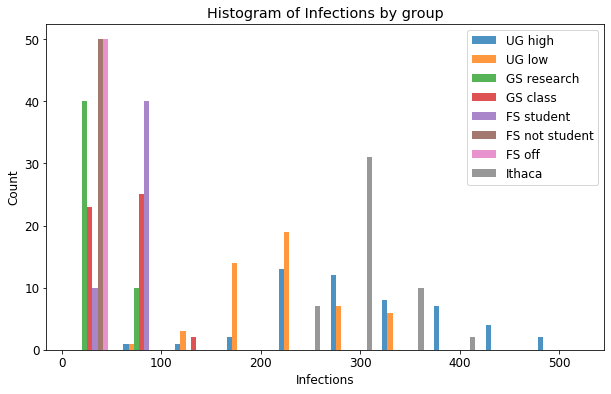

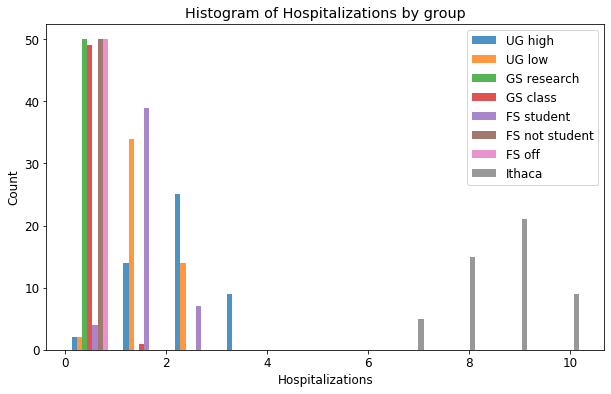

In [165]:
ug_dorm_inf = np.array(results[-2]['inf_matrix'])[:,0]
ug_off_campus_inf = np.array(results[-2]['inf_matrix'])[:,1]
gs_research_inf = np.array(results[-2]['inf_matrix'])[:,2]
gs_other_inf = np.array(results[-2]['inf_matrix'])[:,3]
fs_campus_student_inf = np.array(results[-2]['inf_matrix'])[:,4]
fs_campus_not_student_inf = np.array(results[-2]['inf_matrix'])[:,5]
fs_off_campus_inf = np.array(results[-2]['inf_matrix'])[:,6]
ithaca_community_inf = np.array(results[-2]['inf_matrix'])[:,7]

ug_dorm_hosp = np.array(results[-2]['hosp_matrix'])[:,0]
ug_off_campus_hosp = np.array(results[-2]['hosp_matrix'])[:,1]
gs_research_hosp = np.array(results[-2]['hosp_matrix'])[:,2]
gs_other_hosp = np.array(results[-2]['hosp_matrix'])[:,3]
fs_campus_student_hosp = np.array(results[-2]['hosp_matrix'])[:,4]
fs_campus_not_student_hosp = np.array(results[-2]['hosp_matrix'])[:,5]
fs_off_campus_hosp = np.array(results[-2]['hosp_matrix'])[:,6]
ithaca_community_hosp = np.array(results[-2]['hosp_matrix'])[:,7]

names = ['UG high', 'UG low', 'GS research', 'GS class', 'FS student', 'FS not student', 'FS off', 'Ithaca']

plt.figure(figsize=(10,6))
plt.hist([ug_dorm_inf, ug_off_campus_inf, gs_research_inf, gs_other_inf, fs_campus_student_inf, fs_campus_not_student_inf, fs_off_campus_inf, ithaca_community_inf], label=names, alpha = 0.8)
plt.legend()
plt.ylabel('Count')
plt.xlabel('Infections')
plt.title('Histogram of Infections by group')

plt.figure(figsize=(10,6))
plt.hist([ug_dorm_hosp, ug_off_campus_hosp, gs_research_hosp, gs_other_hosp, fs_campus_student_hosp, fs_campus_not_student_hosp, fs_off_campus_hosp, ithaca_community_hosp], label=names, alpha = 0.8)
plt.legend()
plt.ylabel('Count')
plt.xlabel('Hospitalizations')
plt.title('Histogram of Hospitalizations by group')

## Exploring this solution: [0.33,0.33,0.25,0.33,0.33,0.142857,0.07142857]

In [ ]:
# Sensitivity Analysis
policy = [0.33,0.33,0.25,0.33,0.33,0.142857,0.07142857]
policy_index = test_frac_policies.index(policy)
test_frequencies = [0.142857,0.2,0.25,0.33,0.5]
sensitivity_analysis = dict()
for index, group in enumerate(group_names):
    print('Running sesntivity for ', group)
    if index == 6:
        continue
    group_sensitivity = dict()
    group_sensitivity['test_frequency'] = list()
    group_sensitivity['daily_tests'] = list()
    group_sensitivity['inf'] = list()
    group_sensitivity['inf_low'] = list()
    group_sensitivity['inf_high'] = list()
    group_sensitivity['hosp'] = list()
    group_sensitivity['hosp_low'] = list()
    group_sensitivity['hosp_high'] = list()
    for test_frequency in test_frequencies:
        print('Test Frequency: ', test_frequency)
        if test_frequency == policy[index]: # If this is the same as the simulations that we already ran
            group_sensitivity['test_frequency'].append(test_frequency)
            group_sensitivity['daily_tests'].append(daily_tests[policy_index])
            group_sensitivity['inf'].append(inf[policy_index])
            group_sensitivity['inf_low'].append(inf_low[policy_index])
            group_sensitivity['inf_high'].append(inf_high[policy_index])
            group_sensitivity['hosp'].append(hosp[policy_index])
            group_sensitivity['hosp_low'].append(hosp_low[policy_index])
            group_sensitivity['hosp_high'].append(hosp_high[policy_index])
        else:
            params_list = [ug_dorm_params.copy(), ug_off_campus_params.copy(), gs_research_params.copy(), gs_other_params.copy(), faculty_staff_student_params.copy(), faculty_staff_non_student_params.copy(), faculty_staff_off_campus_params.copy()]
            tests_per_day, inf_matrix, hosp_matrix = evaluate_testing_policy(params_list, interaction_matrix, group_names, policy, 112, 25)
            group_sensitivity['test_frequency'].append(test_frequency)
            group_sensitivity['daily_tests'].append(tests_per_day)
            group_sensitivity['inf'].append(np.quantile(np.sum(inf_matrix, axis=1), 0.5, axis=0))
            group_sensitivity['inf_low'].append(np.quantile(np.sum(inf_matrix, axis=1), 0.1, axis=0))
            group_sensitivity['inf_high'].append(np.quantile(np.sum(inf_matrix, axis=1), 0.9, axis=0))
            group_sensitivity['hosp'].append(np.quantile(np.sum(hosp_matrix, axis=1), 0.5, axis=0))
            group_sensitivity['hosp_low'].append(np.quantile(np.sum(hosp_matrix, axis=1), 0.1, axis=0))
            group_sensitivity['hosp_high'].append(np.quantile(np.sum(hosp_matrix, axis=1), 0.9, axis=0))
    sensitivity_analysis[group] = group_sensitivity

Running sesntivity for  UG (campus)
Test Frequency:  0.142857
